In [94]:
import tensorflow as tf


class DQN(tf.keras.models.Model):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation="relu")
        self.dense2 = tf.keras.layers.Dense(64, activation="relu")
        self.output_layer = tf.keras.layers.Dense(
            action_size, dtype=tf.float32, activation=None
        )

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

In [95]:
from collections import deque
import numpy as np


class ReplayBuffer(object):
    def __init__(self, memory_size) -> None:
        self.buffer = deque(maxlen=memory_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        idx = np.random.choice(len(self.buffer), batch_size)
        for i in idx:
            state, action, reward, next_state, done = self.buffer[i]
            states.append(np.array(state, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states)
        dones = np.array(dones, dtype=np.float32)
        return states, actions, rewards, next_states, dones

In [96]:
num_episodes = 5000
learning_rate = 0.00005
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.9995
batch_size = 128
discount = 0.95
update_target_every = 10
buffer = ReplayBuffer(100000)

In [97]:
import gymnasium as gym

env = gym.make("CartPole-v1")
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

main_model = DQN(action_size)
target_model = DQN(action_size)
target_model.set_weights(main_model.get_weights())

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

In [98]:
def epsilon_greedy_policy(state, epsilon):
    if tf.random.uniform((1,)) < epsilon:
        return env.action_space.sample()
    return tf.argmax(main_model(state)[0]).numpy()


@tf.function
def train_step(states, actions, rewards, next_states, dones):
    next_qs = target_model(next_states)
    max_next_qs = tf.reduce_max(next_qs, axis=-1)
    target = rewards + (1.0 - dones) * discount * max_next_qs
    with tf.GradientTape() as tape:
        qs = main_model(states)
        action_masks = tf.one_hot(actions, action_size)
        qs = tf.reduce_sum(tf.multiply(qs, action_masks), axis=-1)
        loss = loss_fn(target, qs)
    grads = tape.gradient(loss, main_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, main_model.trainable_variables))
    return loss

In [99]:
episode_rewards = []
episode_losses = []
episode_epsilons = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward, done = 0, False
    losses = []
    while not done:
        state_in = tf.expand_dims(state, axis=0)
        action = epsilon_greedy_policy(state_in, epsilon)
        next_state, reward, done, _, info = env.step(action)
        episode_reward += reward
        buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(buffer) < batch_size:
            continue

        states, actions, rewards, next_states, dones = buffer.sample(batch_size)
        loss = train_step(states, actions, rewards, next_states, dones)
        losses.append(loss.numpy())

    if episode % update_target_every == 0:
        target_model.set_weights(main_model.get_weights())

    episode_rewards.append(episode_reward)
    episode_epsilons.append(epsilon)
    if len(losses) > 0:
        episode_losses.append(np.mean(losses))

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if episode % 10 == 0:
        print(
            f"Episode {episode} Reward: {episode_reward} Epsilon: {epsilon:.3f}",
            end=" ",
        )
        if len(losses) > 0:
            print(f"Loss: {np.mean(losses):.3f}")
        else:
            print()

Episode 0 Reward: 27.0 Epsilon: 1.000 
Episode 10 Reward: 11.0 Epsilon: 0.995 Loss: 0.841
Episode 20 Reward: 36.0 Epsilon: 0.990 Loss: 0.666
Episode 30 Reward: 13.0 Epsilon: 0.985 Loss: 0.406
Episode 40 Reward: 18.0 Epsilon: 0.980 Loss: 0.544
Episode 50 Reward: 10.0 Epsilon: 0.975 Loss: 0.741
Episode 60 Reward: 15.0 Epsilon: 0.970 Loss: 1.041
Episode 70 Reward: 13.0 Epsilon: 0.965 Loss: 1.593
Episode 80 Reward: 31.0 Epsilon: 0.960 Loss: 2.149
Episode 90 Reward: 66.0 Epsilon: 0.956 Loss: 2.465
Episode 100 Reward: 11.0 Epsilon: 0.951 Loss: 2.684
Episode 110 Reward: 14.0 Epsilon: 0.946 Loss: 4.139
Episode 120 Reward: 25.0 Epsilon: 0.941 Loss: 3.440
Episode 130 Reward: 14.0 Epsilon: 0.937 Loss: 3.916
Episode 140 Reward: 12.0 Epsilon: 0.932 Loss: 4.107
Episode 150 Reward: 10.0 Epsilon: 0.927 Loss: 3.935
Episode 160 Reward: 15.0 Epsilon: 0.923 Loss: 4.074
Episode 170 Reward: 16.0 Epsilon: 0.918 Loss: 3.611
Episode 180 Reward: 13.0 Epsilon: 0.913 Loss: 3.612
Episode 190 Reward: 27.0 Epsilon: 

KeyboardInterrupt: 

In [ ]:
import time

now = time.strftime("%Y-%m-%d_%H-%M-%S")

main_model.save(f"models/{now}_dqn_cartpole.keras")
hyperparams = {
    "num_episodes": num_episodes,
    "learning_rate": learning_rate,
    "epsilon": epsilon,
    "epsilon_min": epsilon_min,
    "epsilon_decay": epsilon_decay,
    "batch_size": batch_size,
    "discount": discount,
    "update_target_every": update_target_every,
}
np.save(f"hyperparams/{now}_dqn_cartpole_hyperparams.npy", hyperparams)
metrics = {"episode_rewards": episode_rewards, "episode_losses": episode_losses}
np.save(f"metrics/{now}_dqn_cartpole_metrics.npy", metrics)

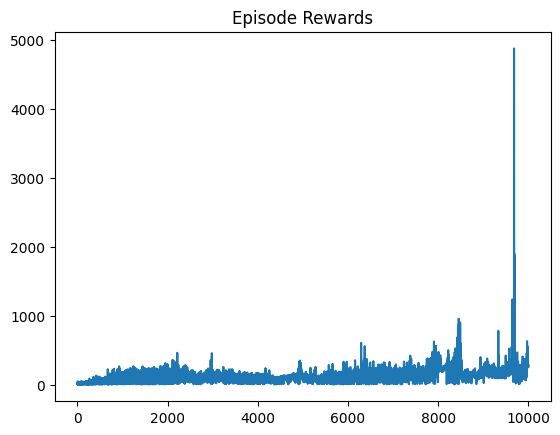

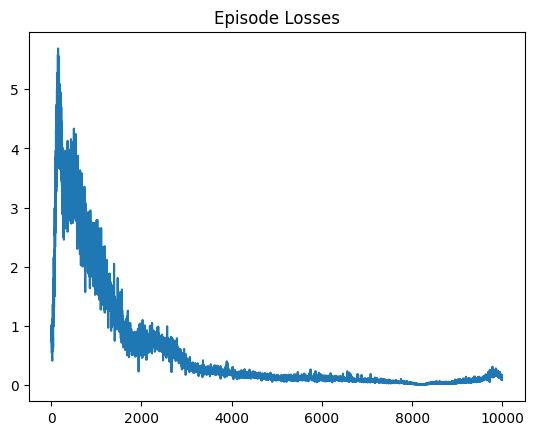

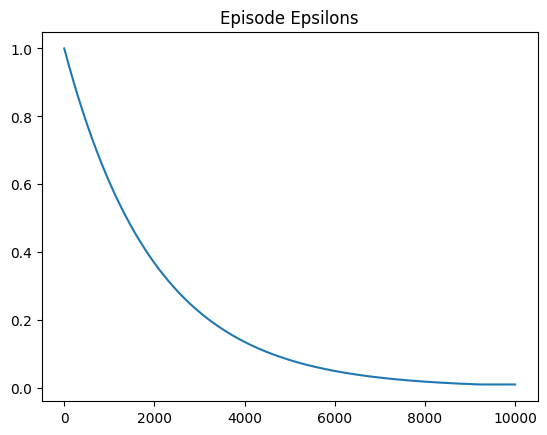

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=episode_rewards)
plt.title("Episode Rewards")
plt.show()

sns.lineplot(data=episode_losses)
plt.title("Episode Losses")
plt.show()

sns.lineplot(data=episode_epsilons)
plt.title("Episode Epsilons")
plt.show()

In [ ]:
import pygame

test_env = gym.make("CartPole-v1", render_mode="human")

evaluation_episodes = 10
for _ in range(evaluation_episodes):
    state, _ = test_env.reset()
    done, truncated = False, False
    total_reward = 0
    while not done and not truncated:
        state_in = tf.expand_dims(state, axis=0)
        action = tf.argmax(main_model(state_in)[0]).numpy()
        state, _, done, truncated, _ = test_env.step(action)

test_env.close()
pygame.quit()